## **Word2Vec Skip-gram**

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# **Read Data**

In [3]:
data = pd.read_csv('data.txt')

In [4]:
data.head()

,1
0,ای رستخیز ناگهان، وی رحمت بی منتها\tای آتشی اف...
1,امروز خندان آمدی، مفتاح زندان آمدی\tبر مستمندا...
2,خورشید را حاجب تویی، امید را واجب تویی\tمطلب ت...
3,در سینه ها برخاسته، اندیشه را آراسته\tهم خویش ...
4,ای روح بخش بی بَدَل، وی لذتِ علم و عمل\tباقی ب...


**Read Stop-Words**

In [5]:
def read_stop_words(filename):
  with open(filename) as stopwords_file:
    stopwords = stopwords_file.readlines()
  stopwords = [line.replace('\n', '') for line in stopwords] 
  return stopwords

In [6]:
stopwords = read_stop_words('stopwords.txt')
print(len(stopwords))

1382


**hazm library**

In [7]:
# install hazm library
!pip install hazm
from hazm import word_tokenize

     |████████████████████████████████| 316 kB 5.4 MB/s 
     |████████████████████████████████| 233 kB 41.2 MB/s 
     |████████████████████████████████| 1.4 MB 48.2 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394485 sha256=52d7ccd818418ca1e57a67ba31a2f8cb79bddba42ea2008b81772532b59d1667
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154474 sha256=cc24d8f6220fe38c34fa1490dd3e255d8086ef8d21173c895f111d1596eb9761
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


### **Preprocess the text**

In [8]:
# preprocess the text
def text_preprocess(data):
  text = [line.replace('\t', ' ') for line in data.values.flatten()]
  text = [line.replace('-', ' ') for line in text]
  text = [re.sub("\d+", "", t) for t in text]

  word_tokenized = [word_tokenize(t) for t in text]
  word_tokenized_filtered = [[w for w in sentence if w not in stopwords] for sentence in word_tokenized]

  sentences = [' '.join(sentence) for sentence in word_tokenized_filtered]
  sentences = [sentence for sentence in sentences if sentence != '']

  return sentences


In [9]:
sentences = text_preprocess(data)

In [10]:
sentences[0]

'رستخیز رحمت منتها آتشی افروخته بیشه اندیشه'

### **get less frequente words**

In [11]:
def get_all_sentences():
  all_sentences = ''
  sentences = text_preprocess(data)
  for sentence in sentences:
    all_sentences += sentence
    all_sentences += ' '

  return all_sentences  

In [12]:
def get_word_freq(vocabularies):
  word_freq = []
  for vocab in vocabularies:
    word_freq.append(vocabularies.count(vocab))
  return word_freq  

In [13]:
# get the words that frequentes less than 2 times in the corpus
def get_less_frequente_words():
  low_frequency_words = []
  all_sentences = get_all_sentences()
  vocabularies = all_sentences.split(' ')
  word_freq = get_word_freq(vocabularies)

  for i in range(len(word_freq)):
    if word_freq[i] < 2:
      low_frequency_words.append(vocabularies[i])

  return low_frequency_words

In [14]:
less_frequente_words = get_less_frequente_words()

In [15]:
print(len(less_frequente_words))

6366


## **remove less frequente words**

In [16]:
# remove the words that frequentes less than 2 times in the corpus
def remove_less_frequente_words(less_frequente_words, sentences):
  sentences_tokenized = [word_tokenize(sentence) for sentence in sentences]
  sentences_tokenized_filtered = [[w for w in sentence if w not in less_frequente_words] for sentence in sentences_tokenized]
  corpus = [' '.join(sentence) for sentence in sentences_tokenized_filtered]
  corpus = [sentence for sentence in corpus if sentence != '']

  return corpus

In [17]:
corpus = remove_less_frequente_words(less_frequente_words, sentences)

In [18]:
corpus[0:10]

['رستخیز رحمت منتها آتشی افروخته بیشه اندیشه',
 'خندان آمدی مفتاح زندان آمدی آمدی بخشش فضل خدا',
 'خورشید حاجب تویی امید واجب تویی مطلب تویی طالب تویی منتها',
 'سینه اندیشه آراسته حاجت روا',
 'روح علم باقی بهانه دغل علت دوا',
 'دغل کژ گنه کین مست مست نان شوربا',
 'هل عقل هل نان نشاید ماجرا',
 'تدبیر رنگ افکنی روم زنگ افکنی جنگ افکنی یری',
 'پنهان گوش جان بهانه کسان جان رب زنان والله کیا',
 'خامش رفتم پای علم کاغذ بنه بشکن قلم ساقی درآمد الصلا']

## **Tokenizer**

In [19]:
# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [20]:
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [21]:
list(tokenizer.word_index.items())[0:10]

[('جان', 1),
 ('دل', 2),
 ('عشق', 3),
 ('آب', 4),
 ('چشم', 5),
 ('شب', 6),
 ('جهان', 7),
 ('شمس', 8),
 ('دست', 9),
 ('مست', 10)]

In [22]:
 # find more stopwords by sorting the tokenizer word counts
#  word_count_sorted = dict(sorted(tokenizer.word_counts.items(), reverse=False, key=lambda t: t[1]))
#  word_count_sorted

In [23]:
encoded = tokenizer.texts_to_sequences(corpus)

In [24]:
encoded[0:10]

[[2726, 283, 1337, 397, 1610, 967, 143],
 [185, 568, 1124, 398, 568, 568, 830, 332, 23],
 [46, 2727, 29, 636, 2031, 29, 831, 29, 258, 29, 1337],
 [92, 143, 1338, 727, 728],
 [30, 221, 162, 399, 1611, 968, 244],
 [1611, 729, 2032, 569, 10, 10, 209, 2728],
 [464, 13, 464, 209, 1125, 419],
 [969, 104, 1612, 352, 1126, 1612, 192, 1612, 730],
 [77, 41, 1, 399, 1613, 1, 259, 245, 284, 1127],
 [201, 731, 56, 221, 2729, 377, 732, 1128, 31, 570, 186]]

In [25]:
num_all_words = sum(len(s) for s in encoded) # total number of words in the corpus
num_unique_words = len(tokenizer.word_index) + 1  # total number of unique words in the corpus

In [26]:
num_all_words, num_unique_words

(32654, 4284)

### **Generate data**

In [27]:
# Parameters
window_size = 2

In [28]:
def generate_data(corpus, window_size, num_unique_words):
    maxlen = window_size * 2
    all_inputs = []
    all_outputs = []
    for words in corpus:
      len_words = len(words)
      for index,w in enumerate(words):
        s = index - window_size
        e = index + window_size + 1
        for i in range(s, e):
            if i != index and 0 <= i < len_words:
              all_inputs.append(w) 
              #all_inputs.append(to_categorical(w, num_unique_words)) 
              all_outputs.append(to_categorical(words[i], num_unique_words))

    return (np.array(all_inputs), np.array(all_outputs))

In [29]:
# Create training data
X_train, y_train = generate_data(encoded, window_size, num_unique_words)
X_train.shape, y_train.shape

((98832,), (98832, 4284))

In [30]:
X_train, y_train

(array([2726, 2726,  283, ...,  619, 1810, 1810]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [31]:
# for i in X_train:
#   print(np.where(i == 1))
print(np.where(X_train[0] == 1))

(array([], dtype=int64),)


## **Create Neural Network**

In [32]:
embed_size=100
model = Sequential()
model.add(Embedding(input_dim=num_unique_words, output_dim=embed_size, input_length=1, embeddings_initializer='glorot_uniform'))
model.add(Reshape((embed_size, )))
model.add(Dense(num_unique_words, activation='softmax', kernel_initializer='glorot_uniform'))

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 100)            428400    
                                                                 
 reshape (Reshape)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 4284)              432684    
                                                                 
Total params: 861,084
Trainable params: 861,084
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(X_train, y_train, epochs=300, verbose=1, batch_size=1024)

Epoch 1/300
97/97 [==============================] - 12s 116ms/step - loss: 8.3305 - accuracy: 0.0185
Epoch 2/300
97/97 [==============================] - 11s 116ms/step - loss: 8.0868 - accuracy: 0.0278
Epoch 3/300
97/97 [==============================] - 11s 116ms/step - loss: 7.6407 - accuracy: 0.0274
Epoch 4/300
97/97 [==============================] - 11s 118ms/step - loss: 7.4582 - accuracy: 0.0292
Epoch 5/300
97/97 [==============================] - 11s 117ms/step - loss: 7.3597 - accuracy: 0.0310
Epoch 6/300
97/97 [==============================] - 11s 116ms/step - loss: 7.2707 - accuracy: 0.0345
Epoch 7/300
97/97 [==============================] - 11s 117ms/step - loss: 7.1752 - accuracy: 0.0381
Epoch 8/300
97/97 [==============================] - 11s 117ms/step - loss: 7.0710 - accuracy: 0.0421
Epoch 9/300
97/97 [==============================] - 11s 118ms/step - loss: 6.9593 - accuracy: 0.0458
Epoch 10/300
97/97 [==============================] - 11s 117ms/step - loss: 6.841

## **Save Model**

In [69]:
model.save('model_skipgram.h5')

## **Load Model**

In [70]:
# laod model
model = load_model('model_skipgram.h5')

In [71]:
model

### **Get Most Similarity**

In [65]:
with open('tokenizer.h5', 'rb') as f:
    tokenizer = pickle.load(f)

In [66]:
def get_most_similarity(word, model=model, tokenizer=tokenizer, n=15):
  num_unique_words = len(tokenizer.word_index) + 1
  word_to_sequences = tokenizer.texts_to_sequences([word])[0]
  prediction = model.predict(word_to_sequences)[0]
  index = np.argsort(prediction)[::-1][:n]
  sequences_to_word = tokenizer.sequences_to_texts([index])[0]
  most_similarity = sequences_to_word.split(' ')
  return most_similarity

In [67]:
get_most_similarity('عشق')

['عشق',
 'جان',
 'دل',
 'عقل',
 'آتش',
 'جمله',
 'شاه',
 'شمس',
 'عاشقان',
 'مست',
 'دست',
 'جهان',
 'گشته',
 'عالم',
 'گذر']

In [68]:
get_most_similarity('شمس')

['تبریزی',
 'تبریز',
 'دین',
 'الدین',
 'الحق',
 'مفخر',
 'عشق',
 'جان',
 'خداوند',
 'نور',
 'الضحی',
 'دل',
 'مخدوم',
 'شمس',
 'دست']

In [52]:
get_most_similarity('کنج')

['عاشق',
 'ای',
 'خلا',
 'کنجی',
 'درآرد',
 'زندان',
 'نرسم',
 'نشین',
 'کنج',
 'خری',
 'درگاه',
 'بهاری',
 'متاع',
 'خندان',
 'طلب']

## **Get Weights and draw plot**

In [53]:
# get input weights
weights = model.get_weights()[0]

In [54]:
len(weights)

4284

In [55]:
embedding_dict = {}
for word,index in tokenizer.word_index.items(): 
    embedding_dict.update({
        word: weights[index]
        })

In [56]:
list(embedding_dict.items())[0]

('جان', array([ 0.21803653, -0.4955872 ,  0.9019896 ,  0.8629778 , -0.10063481,
         0.7740619 ,  0.01459885,  0.23545955, -0.11691605,  0.6817756 ,
         0.82904565, -0.6871457 ,  0.49880704, -0.36091098, -0.39975455,
         0.3312609 , -0.24594858,  0.41170692, -1.0126475 ,  0.14731568,
         0.08652279,  1.0010389 ,  0.3810352 , -0.42515424,  0.24387066,
        -0.3018596 , -0.49036306,  0.45977932,  0.20962167, -0.48633924,
         0.4694727 , -0.13206173, -0.4625077 , -0.01515568, -0.3016097 ,
         0.04617103,  0.52853286,  0.45443246,  0.04037209, -0.05961623,
        -0.29597753,  0.22008039,  0.5463413 , -0.6185917 , -0.14853558,
        -0.12503739, -0.5803198 , -0.23884249,  0.06351489,  0.5394788 ,
        -0.6357991 ,  0.6393451 , -0.02559292,  0.4729697 ,  0.02404849,
         0.12527804,  0.63323545,  0.48199078, -0.04284623,  0.064722  ,
         0.2549851 , -0.32260442,  0.5029634 , -0.84748495, -0.32817477,
         0.02045304, -0.23268053, -0.2087046

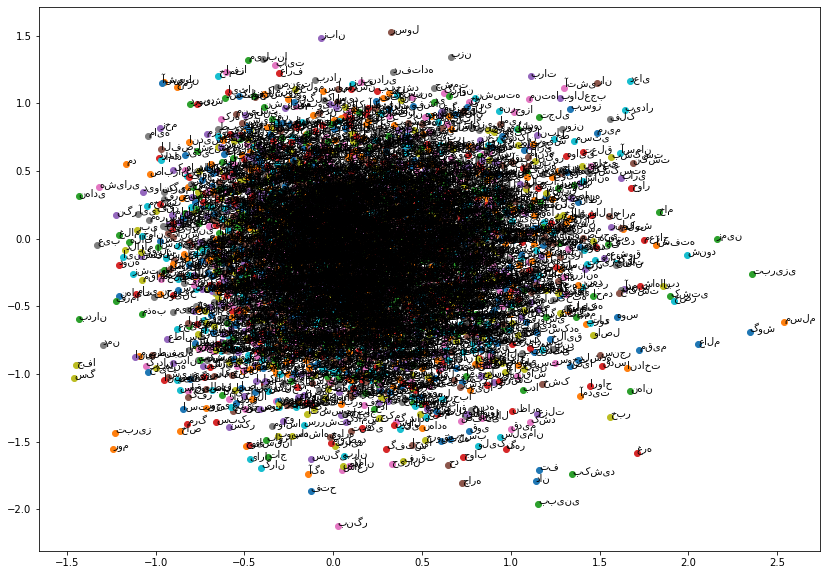

In [57]:
plt.figure(figsize=(14, 10))
for word in list(tokenizer.word_index.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))  